<a href="https://colab.research.google.com/github/li199959/one/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1,   300] loss: 0.661
[1,   600] loss: 0.210
[1,   900] loss: 0.156
Accuracy on test  set: 96 %
[2,   300] loss: 0.117
[2,   600] loss: 0.108
[2,   900] loss: 0.100
Accuracy on test  set: 97 %
[3,   300] loss: 0.082
[3,   600] loss: 0.081
[3,   900] loss: 0.075
Accuracy on test  set: 97 %
[4,   300] loss: 0.066
[4,   600] loss: 0.068
[4,   900] loss: 0.065
Accuracy on test  set: 98 %
[5,   300] loss: 0.056
[5,   600] loss: 0.060
[5,   900] loss: 0.059
Accuracy on test  set: 98 %
[6,   300] loss: 0.053
[6,   600] loss: 0.052
[6,   900] loss: 0.053
Accuracy on test  set: 98 %
[7,   300] loss: 0.047
[7,   600] loss: 0.047
[7,   900] loss: 0.051
Accuracy on test  set: 98 %
[8,   300] loss: 0.042
[8,   600] loss: 0.050
[8,   900] loss: 0.040
Accuracy on test  set: 98 %
[9,   300] loss: 0.045
[9,   600] loss: 0.042
[9,   900] loss: 0.037
Accuracy on test  set: 98 %
[10,   300] loss: 0.040
[10,   600] loss: 0.034
[10,   900] loss: 0.041
Accuracy on test  set: 98 %
[96.45, 97.51, 97.69, 98.27

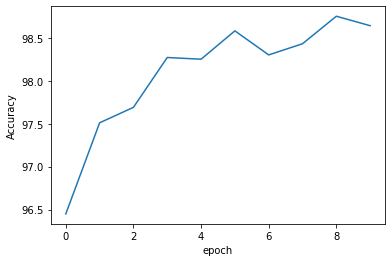

In [9]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# 1、准备数据集
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_dataset = datasets.MNIST(root='dataset/mnist',
                               train=True,
                               download=True,
                               transform=transform)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_dataset = datasets.MNIST(root='dataset/mnist',
                              train=False,
                              download=True,
                              transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# 2、建立模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(320, 10)

    def forward(self, x):
        batch_size = x.size(0) # x的第0维就是batch_size
        x = F.relu(self.pooling(self.conv1(x))) # 修正与池化顺序反了但是不影响
        x = F.relu(self.pooling(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x


model = Net()
# 将模型迁移到GPU上运行，cuda:0表示第0块显卡
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())
model.to(device)

# 3、建立损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


# 4、定义训练函数
def train(epoch):
    running_loss = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        # 将要计算的张量也迁移到GPU上——输入和输出
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        # 前馈 反馈 更新
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0

# 5、定义测试函数
accuracy = []
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # 测试中的张量也迁移到GPU上
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            # 两个张量比较，得出的是其中相等的元素的个数（即一个批次中预测正确的个数）
            correct += (predicted == labels).sum().item()
    print('Accuracy on test  set: %d %%' % (100 * correct / total))
    accuracy.append(100 * correct / total)


if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test()
    print(accuracy)
    plt.plot(range(10), accuracy)
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.show()
